# Analysis

## Build base corpus for semanticlayertools

In [7]:
import os
import requests

In [2]:
from semanticlayertools.linkage.cocitation import Cocitations
from semanticlayertools.clustering.leiden import TimeCluster
from semanticlayertools.clustering.reports import ClusterReports

In [3]:
from semanticlayertools.visual.utils import streamgraph

In [4]:
import pandas as pd
from tqdm import tqdm
import dimcli
dimcli.login()
dsl = dimcli.Dsl()

Searching config file credentials for default 'live' instance..


Dimcli - Dimensions API Client (v0.9.6)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.0
Method: dsl.ini file


This routine makes use of the _Research Organization Registry_ which contains data for relation among research organizations. This allows to query for sub-organizations in relation to a parent. The __baseOrgID__ in this case is the Max Planck Society: [https://ror.org/01hhn8329](https://ror.org/01hhn8329)

In [40]:
orgName = "MPG"

In [37]:
baseOrgID = "01hhn8329"

In this notebook we are interested in an earlier phase of the MPG and therefore limit the query for publications.

In [36]:
yearStart = 1945
yearEnd = 1970
yearRange = range(yearStart, yearEnd, 1)

In [38]:
basepath = "./basedata/"

### Determine grid IDs of children for parent organization

Since DimensionsAI makes use of the GRID identifiers, we first create a list of GRID IDs for all children organizations of the MPG.

In [30]:
baseurl = "https://api.ror.org/organizations/"

In [31]:
res = requests.get(f'{baseurl}{baseOrgID}')

In [32]:
orgChildren = [x['id'] for x in res.json()['relationships']]

In [33]:
orgChildIDs = []
for child in orgChildren:
    res = requests.get(f'{baseurl}{child}')
    orgChildIDs.append(
        res.json()['external_ids']['GRID']['all']
    )
    

Note that some organizations might have several IDs. This is not the case for this query however.

In [35]:
len(orgChildIDs)

107

### Query for available publications

Using the DimensionsAI CLI, dimcli, we can create a query for each grid ID. If for a grid ID data is found in the given timeframe, a record is created for later processing which year, id, references, title and authors of each publication found.

In [39]:
%%time
for gridid in tqdm(orgChildIDs):
    query = f"""search publications
        where year in [{yearStart}:{yearEnd}] and research_orgs="{gridid}"
        return publications[year+id+reference_ids+title+authors] sort by year"""
    res = dsl.query_iterative(query, verbose=False)
    dfRes = res.as_dataframe()
    if dfRes.shape[0] > 0:
        dfRes.to_json(f'{basepath}{gridid}.json', orient='records', lines=True)

100%|█████████████████████████████████████████| 107/107 [04:15<00:00,  2.39s/it]

CPU times: user 4.88 s, sys: 344 ms, total: 5.23 s
Wall time: 4min 15s


### Preprocess base corpus

The retrieved data has to be reworked slightly to fit the format of the _semanticlayertools_ package. From the author information, affiliations and fullnames of multiple authors are joined with semincolons. Then the full corpus is split into years and exported to the folder _corpus_.

In [41]:
files = [x for x in os.listdir(basepath) if x.endswith('.json')]

In [43]:
resDF = []
for x in files:
    dfT = pd.read_json(f'{basepath}{x}', lines=True)
    dfT.insert(0, 'org', x[:-5])
    resDF.append(dfT)

In [44]:
dfall = pd.concat(resDF)

In [45]:
dfall.shape

(6254, 6)

In [46]:
dfall.head(2)

org                                            authors  \
0  grid.419604.e  [{'affiliations': [{'city': 'Stony Brook', 'ci...   
1  grid.419604.e  [{'affiliations': [{'city': 'Heidelberg', 'cit...   

               id                                      reference_ids  \
0  pub.1062501435  [pub.1062498890, pub.1062498889, pub.106249893...   
1  pub.1062499600  [pub.1044841340, pub.1003581711, pub.101588479...   

                                               title  year  
0  Potassium-Argon Ages of Lunar Rocks from Mare ...  1970  
1  Fission Track Ages and Ages of Deposition of D...  1970

In [47]:
affStr = dfall.authors.apply(lambda row: ';'.join(['+'.join([y['name'] for y in x['affiliations']]) for x in row]) if type(row)==list else 'NoAff')

In [48]:
authorStr = dfall.authors.apply(lambda row: ';'.join([x['first_name'] + ' ' + x['last_name'] for x in row]) if type(row)==list else 'NoAuthor')

In [49]:
dfall = dfall.drop('authors', axis=1)
dfall.insert(0, 'aff', affStr)
dfall.insert(0, 'authors', authorStr)

In [50]:
dfall.head(2)

authors  \
0  O. A. Schaeffer;J. G. Funkhouser;D. D. Bogard;...   
1     W. Gentner;B. P. Glass;D. Storzer;G. A. Wagner   

                                                 aff            org  \
0  Stony Brook University;Stony Brook University;...  grid.419604.e   
1  Max Planck Institute for Nuclear Physics;Godda...  grid.419604.e   

               id                                      reference_ids  \
0  pub.1062501435  [pub.1062498890, pub.1062498889, pub.106249893...   
1  pub.1062499600  [pub.1044841340, pub.1003581711, pub.101588479...   

                                               title  year  
0  Potassium-Argon Ages of Lunar Rocks from Mare ...  1970  
1  Fission Track Ages and Ages of Deposition of D...  1970

In [51]:
dfall.to_csv(f'./{orgName}_full.csv', index=False)

In [52]:
for year, g0 in dfall.groupby('year'):
    g0[['org','year','id','authors','aff','title','reference_ids']].to_json(f'./corpus/{orgName}_{year}.json', orient="records", lines=True)

## Apply cocitation clustering

We can now apply the clustering method for the cocitation network of this corpus. As a first step we create the network of cocitation for each year slice. 

### Build cocitation networks

The cocitation network is created by linking pairs of references, if they appear in the same publication. A link is dated with the cociting papers year. 

In [53]:
semCocite = Cocitations(
    inpath = './corpus/',
    outpath = './cocitation/',
    columnName = "reference_ids",
)

In [54]:
semCocite.processFolder()

As a first measure of the data quality, we can create a plot of the amount of nodes and edges contained in the giant component. 

In [55]:
gcEvol = pd.read_csv('./cocitation/Giant_Component_properties.csv')

<AxesSubplot:xlabel='year'>

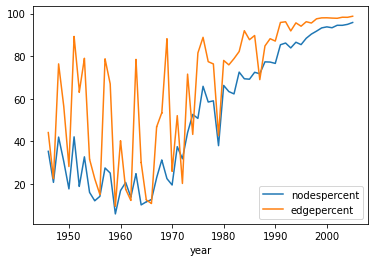

In [56]:
gcEvol.sort_values('year').set_index('year')[['nodespercent', 'edgepercent']].plot()

For the timeframe considered, the giant component contains only around 30 percent of all nodes. An analysis of the full data, not only the giant component, could therefore be advisable.

### Find time clusters

In [57]:
timeClustering = TimeCluster(
    inpath = './cocitation/',
    outpath = './clusters/',
    timerange = (yearStart, yearEnd)
)

Graphs between 1946 and 1970 loaded in 2.7144150733947754 seconds.


In [58]:
outfile, clusteredData = timeClustering.optimize()

	Set layers.
	Set partitions.
	Set interslice partions.
Finished in 9.795211791992188 seconds.Found 76 clusters, with 1 larger then 1000 nodes.


### Visualize cluster evolution

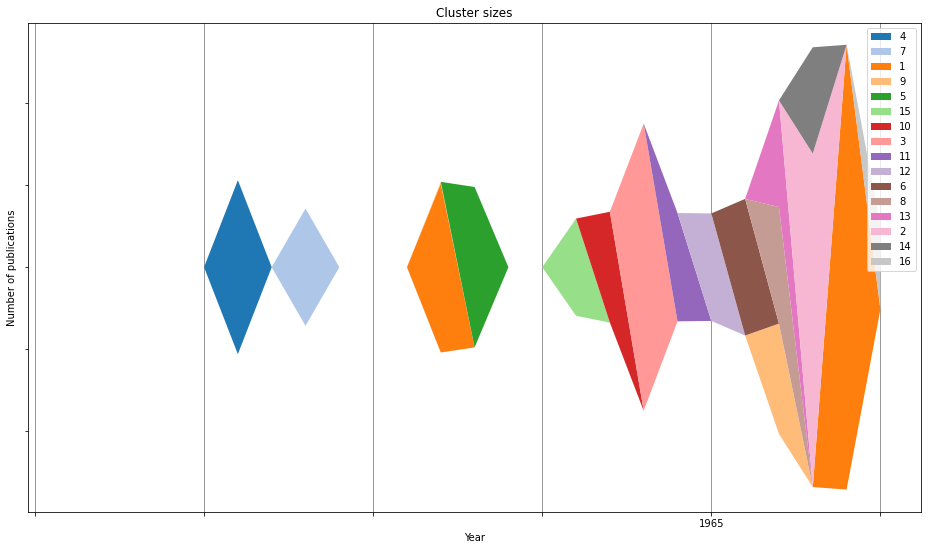

In [62]:
streamgraph(
    outfile,
    minClusterSize = 200,
    smooth=True,
);

## Generate cluster reports for inspection

In [67]:
generateRep = ClusterReports(
    infile = outfile,
    metadatapath = './corpus/',
    outpath = "./reports/",
    authorColumnName = "authors",
    publicationIDcolumn='id',
    numberProc = 4,
    minClusterSize = 200,
)

In [68]:
generateRep.gatherClusterMetadata()

In [ ]:
generateRep.writeReports()

In [73]:
! head -n 40 './reports/timeclusters_1945-1970_res_0.003_intersl_0.4/Cluster_1.txt'

Report for Cluster 1

Got 1488 unique publications in time range: 1957 to 1969.
    Found metadata for 44 publications.
    There are 1466 publications without metadata.

    The top 20 authors of this cluster are:
    	Richard Kuhn: 44
	Adeline Gauhe: 14
	Hans Helmut Baer: 12
	Irmentraut Löw: 6
	Werner Kirschenlohr: 6
	Heinrich Trischmann: 4
	Reinhard Brossmer: 4
	H. J. Haas: 2
	Hans Helmut Baaer: 2
	Gerd Krüger: 2
	Franz Haber: 2
	Heinz Tiedemann: 2
	Gerd Krüuger: 2
	Paul György: 2
	John R.E. Hoover: 2
	Catharine S. Rose: 2
	Hans W. Ruelius: 2
	Friedrich Zilliken: 2
	Heinz Schretzmann: 2
	H. Trischmann: 2


    The top 20 affiliations of this cluster are:
    	Max Planck Institute for Medical Research: 102
	Max Planck Institute for Medical Research+University of Pennsylvania+University of Pennsylvania: 14


    

	Topics in cluster for 15 topics:
		topic 0: konstitution   die   solanin   lacto‐n‐biose   konstitution der lacto‐n‐biose   des   der   ‐trimethyl‐d‐galaktose   glucose   f